In [1]:
from scipy.io.arff import loadarff
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score



In [ ]:
############################## DATA #######################################

In [65]:
# --- récupère les données
def getData(dataset):
    array = []
    for i in dataset[0]:
        try:
            array.append([i['a0'],i['a1']])
        except ValueError:
            array.append([i['x'],i['y']])
    return array

dataRef = (getData(loadarff(open("./donnees/2d-10c.arff",'r'))), 'Données de référence : 2d-10c',9)
dataNconvexe = (getData(loadarff(open("./donnees/rings.arff",'r'))), 'Données non convexes : rings',3)
dataMsep = (getData(loadarff(open("./donnees/elly-2d10c13s.arff",'r'))), 'Données mal séparées : elly-2d10c13s',10)
dataDens = (getData(loadarff(open("./donnees/sizes5.arff",'r'))), 'Données à densité variable : sizes5',4)
dataBruit = (getData(loadarff(open("./donnees/cure-t2-4k.arff",'r'))), 'Données bruitées : cure-t2-4k',7)


dataArray = [dataRef,dataNconvexe,dataMsep,dataDens,dataBruit]


In [4]:
print(loadarff(open("./donnees/cure-t2-4k.arff",'r')))

(array([(-0.590353 , -0.566736 , b'0'), (-0.147896 , -0.257437 , b'0'),
       ( 0.0554175, -0.760445 , b'0'), ...,
       ( 0.4134   ,  0.0177079, b'noise'),
       ( 0.942855 ,  0.56141  , b'noise'),
       (-0.174301 ,  0.520809 , b'noise')],
      dtype=[('x', '<f8'), ('y', '<f8'), ('class', 'S5')]), Dataset: cure-t2-4k
	x's type is numeric
	y's type is numeric
	class's type is nominal, range is ('0', '1', '2', '3', '4', '5', 'noise')
)


In [ ]:
########################## PLOT ############################################

In [5]:
# --- plot les données brut
def plotNoColor(dataset):
    data = dataset[0]
    title = dataset[1]
    plt.figure(1)
    plt.title(title)
    for i in range(0,len(data)):
        plt.scatter(data[i][0],data[i][1],color='b')
        
    plt.show()
    

In [63]:
# --- plot les données avec une couleur associée à chaque cluster
intToCol = [[np.random.rand(3,)] for c in range(0,800)]

def plotColor(dataset, prediction):
    data = dataset[0]
    title = dataset[1]
    
    plt.figure(1)
    
    for i in range(0,len(data)):
        col = intToCol[prediction[i]]
        plt.scatter(data[i][0],data[i][1],c=col)
    plt.title(title)
    plt.show()
    

In [ ]:
###################### EVALUATION ####################################""""""

In [7]:
def evaluate_score(data,pred):   
    # entre -1 et +1, plus c'est haut, plus c'est dense et bien séparés
    # autour de 0, les clusters se chevauchent
    # plus haut pour les convexes
    val1 = silhouette_score(data,pred)
    #print("silhouette: "+ str(val1))

    # plus c'est haut, plus c'est dense et bien séparés
    # plus haut pour les convexes
    val2 = calinski_harabasz_score(data, pred)
    #print("calinski_harabasz : "+ str(val2))

    # plus bas possible = 0, plus proche de zero = mieux cluster
    # plus haut pour les convexes
    val3 = davies_bouldin_score(data, pred)
    #print( "davies_bouldin : "+ str(val3))

    return (val1,val2,val3)

In [84]:
########################### kmeans #################################""

In [9]:
# ------------------------ ALGO KMEANS --------------------------------
def kmean_pred(nb_cluster,data):
    # parametres pour le kmeans
    kmeans = KMeans(n_clusters=nb_cluster,init='k-means++')

    # calcul le temps d'exe
    start = time.time()

    # training
    kmeans.fit(data)

    tmps = time.time()-start

    # prediction
    pred = kmeans.predict(data)
    return (pred,tmps)


tmps : 0.06832218170166016


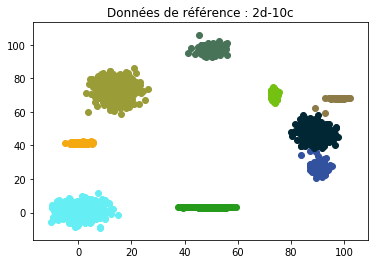

In [23]:
# ----------------------------- TESTS ------------------------------
# application de kmeans sur le jeux de données de reference
pred, tmps = kmean_pred(dataRef[2],dataRef[0])
print("tmps : " + str(tmps))
plotColor(dataRef,pred)

In [57]:
# --- plot les 3 scores et le temps d'execution en fonction du nombre de cluster
def find_nb_clus_kmeans(dataset):
    data = dataset[0]
    title = dataset[1]
    sil = []
    cal = []
    dav = []
    tmps = []

    rng = range(2,15)
    
    for i in rng:
        # predit avec un nb de cluster
        pred,tmp = kmean_pred(i,data)
        tmps.append(tmp)
        # evalue
        a,b,c = evaluate_score(data,pred)
        sil.append(a)
        cal.append(b)
        dav.append(c)
        
    # plot 
    plt.figure(figsize=(10,6))
    plt.suptitle(title)
    plt.subplot(221)
    plt.title('Silhouette Coefficient')
    plt.xlabel('Number of clusters')
    plt.plot(rng,sil,'r')
    
    plt.subplot(222)
    plt.title('Calinski-Harabasz Index')
    plt.xlabel('Number of clusters')
    plt.plot(rng,cal,'b')
    
    plt.subplot(223)
    plt.title('Davies-Bouldin Index')
    plt.xlabel('Number of clusters')
    plt.plot(rng,dav,'g')
    
    plt.subplot(224)
    plt.title('Execution Time')
    plt.ylabel('Time(s)')
    plt.xlabel('Number of clusters')
    plt.plot(rng,tmps,'y')
    plt.subplots_adjust(hspace = 0.5)

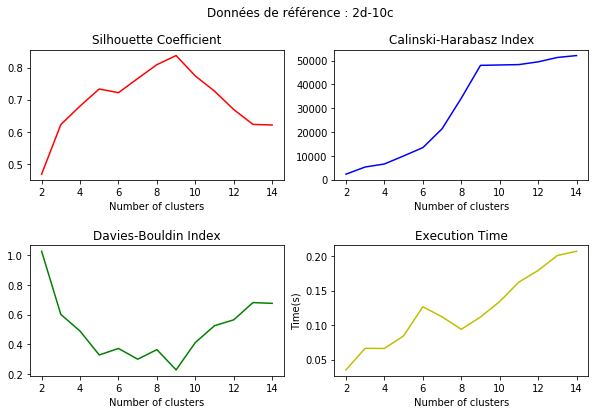

In [58]:
# --- effectue les scores pour le dataset de reference
find_nb_clus_kmeans(dataRef)

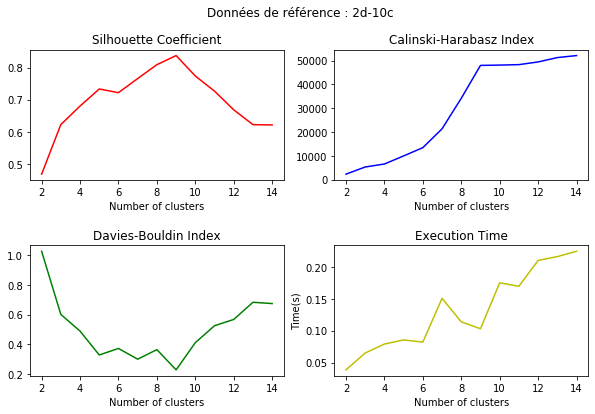

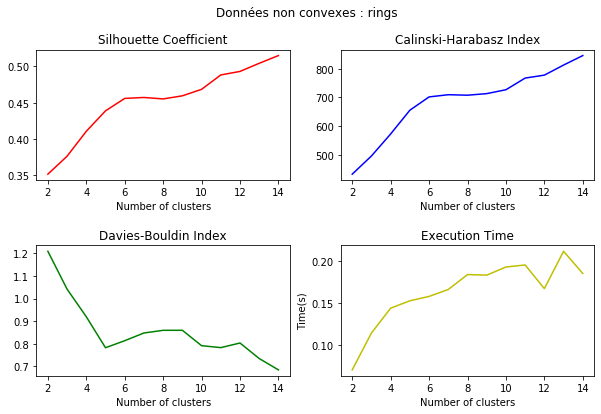

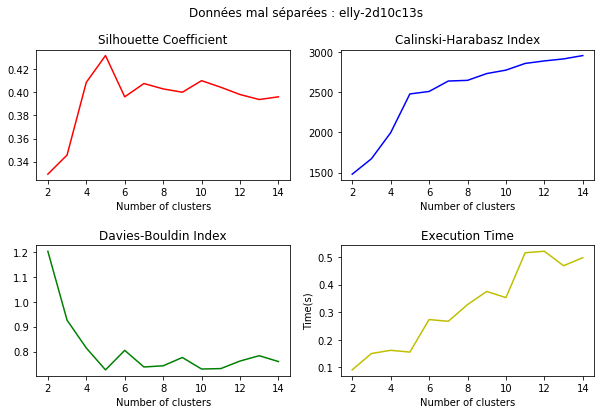

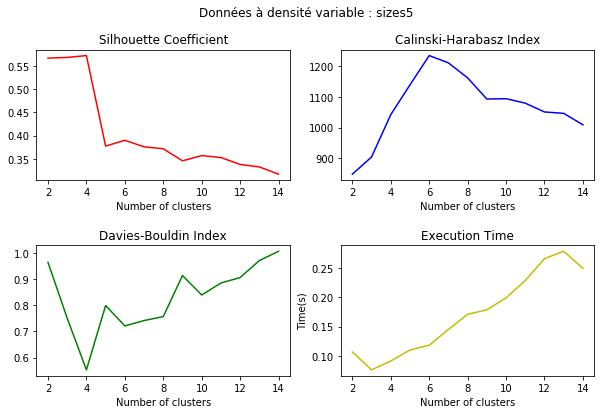

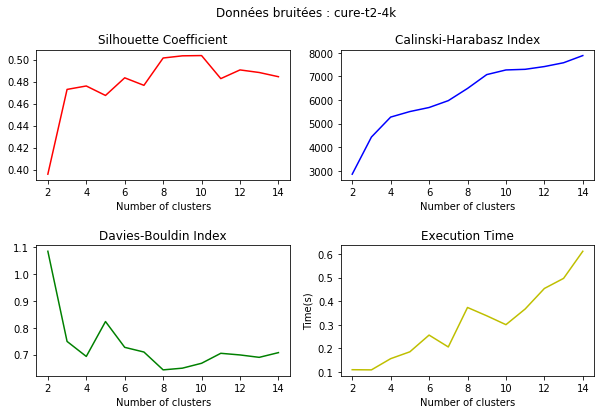

In [66]:
# evaluer le nombre de cluster pour tous les dataset
for i in dataArray:
    find_nb_clus_kmeans(i)

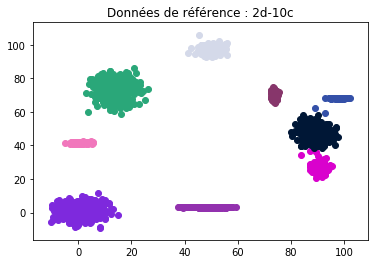

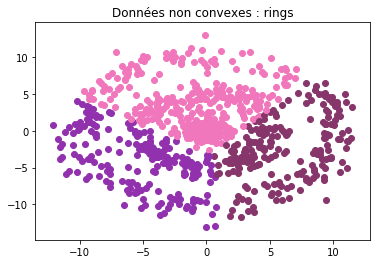

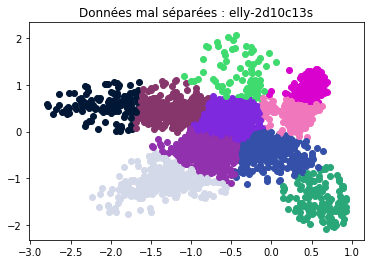

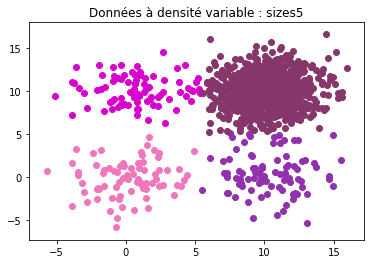

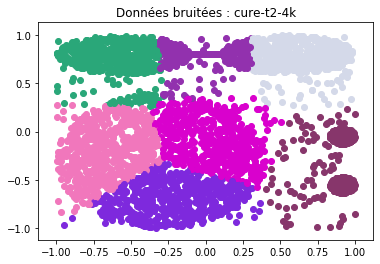

In [67]:
# test sur tous les dataset avec le bon nombre de cluster
for i in dataArray:
    pred,tmps = kmean_pred(i[2],i[0])
    plotColor(i,pred)

In [ ]:
########################### agglomerate #################################

In [54]:
from sklearn.cluster import AgglomerativeClustering

def agglo_pred(nb_cluster,link, data):
    # parametres pour le kmeans
    agglo = AgglomerativeClustering(n_clusters=nb_cluster,linkage=link)

    # calcul le temps d'exe
    start = time.time()

    # training
    agglo.fit(data)

    tmps = time.time()-start

    # prediction
    pred = agglo.fit_predict(data)
    return (pred,tmps)


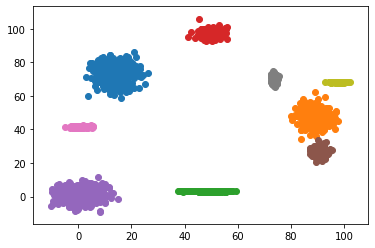

In [57]:
pred,tmps = agglo_pred(9,'ward',dataRef[0])
plotColor(dataRef[0],pred)

single
0.04745221138000488


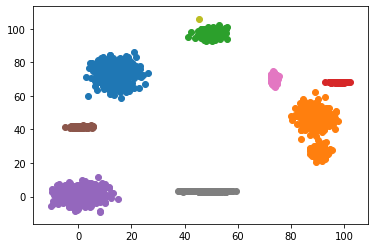

sil : 0.7373288555059309
cal : 17443.354647831755
dav : 0.2696200817951743
average
0.10833525657653809


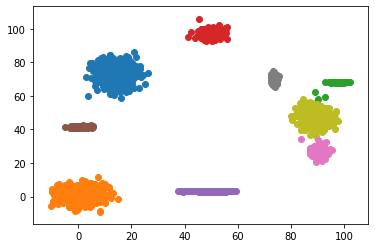

sil : 0.8373633000685332
cal : 47931.40271262782
dav : 0.2288104436854155
complete
0.11262917518615723


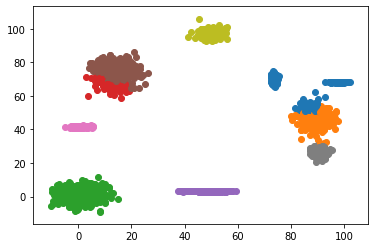

sil : 0.6856057085634313
cal : 25318.401620648398
dav : 0.6068522861630083
ward
0.1302950382232666


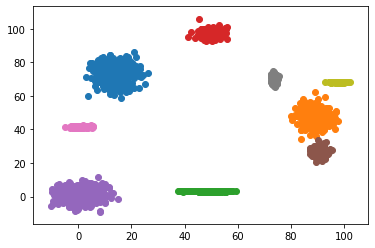

sil : 0.8374016743635769
cal : 47740.29038468033
dav : 0.22766794021035228


In [60]:
# test des linkage sur les datat ref
linkages = ['single','average','complete','ward']
for l in linkages:
    pred,tmps = agglo_pred(9,l,dataRef[0])
    print(l)
    print(tmps)
    plotColor(dataRef[0],pred)
    sil,cal,dav = evaluate_score(dataRef[0],pred)
    print("sil : "+ str(sil))
    print("cal : "+ str(cal))
    print("dav : "+ str(dav))

In [61]:
def find_nb_clus_agglo(data):
    sil = []
    cal = []
    dav = []
    tmps = []

    rng = range(2,15)
    
    for i in rng:
        # predit avec un nb de cluster
        pred,tmp = agglo_pred(i,'ward',data)
        tmps.append(tmp)
        # evalue
        a,b,c = evaluate_score(data,pred)
        sil.append(a)
        cal.append(b)
        dav.append(c)
        
    # plot 
    plt.figure()
    plt.plot(rng,sil,'r')
    plt.figure()
    plt.plot(rng,cal,'b')
    plt.figure()
    plt.plot(rng,dav,'g')
    plt.figure()
    plt.plot(rng,tmps,'y')
    


ref
convexe
sep
dens
bruit


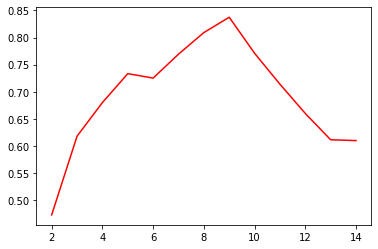

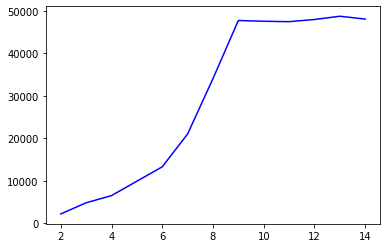

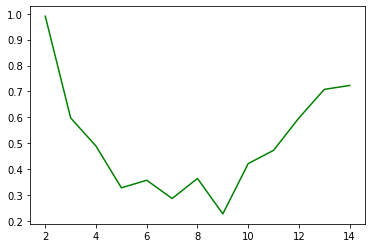

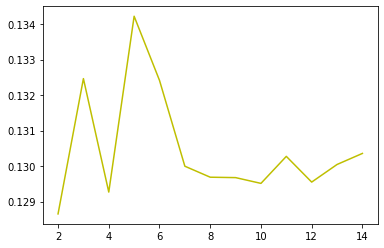

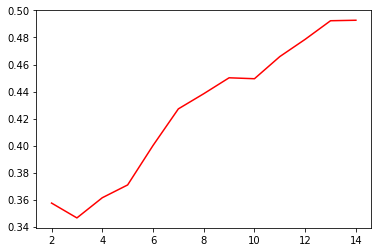

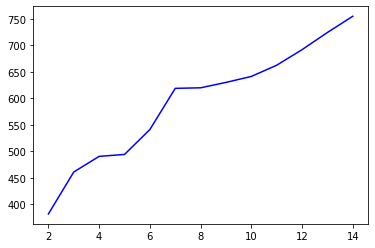

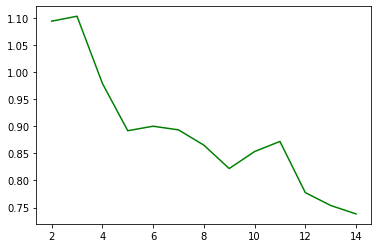

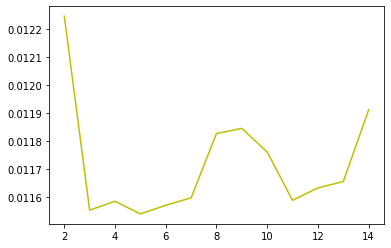

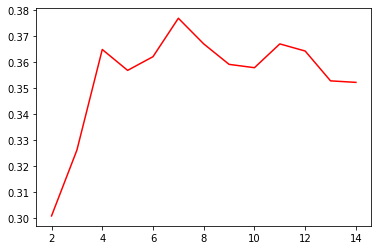

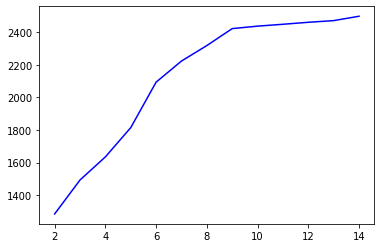

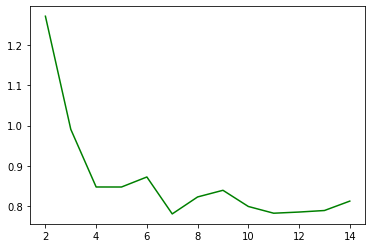

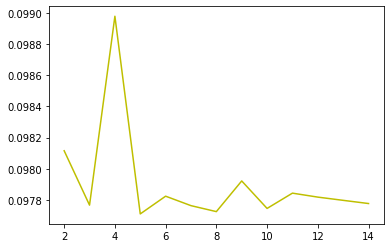

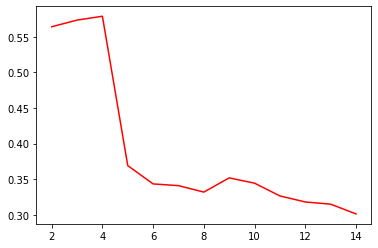

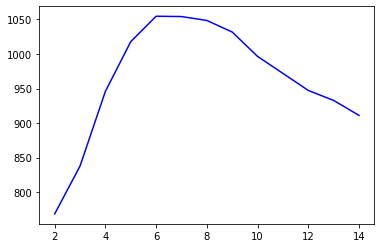

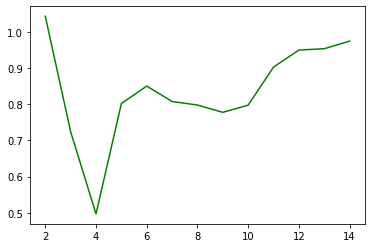

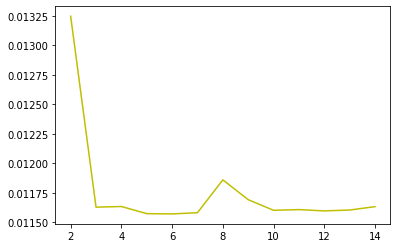

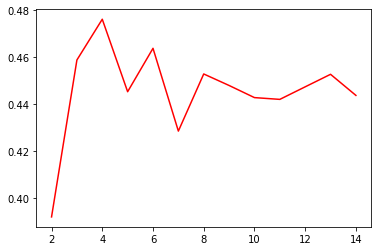

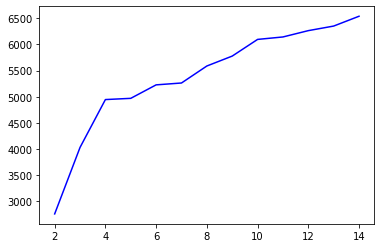

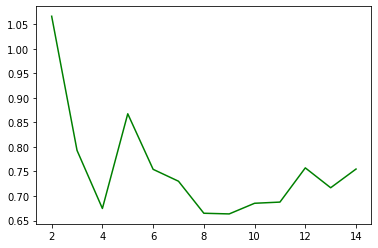

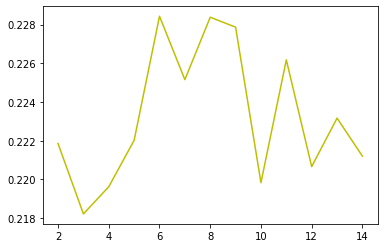

In [62]:
for i in dataArray:
    print(i[1])
    find_nb_clus_agglo(i[0])

ref


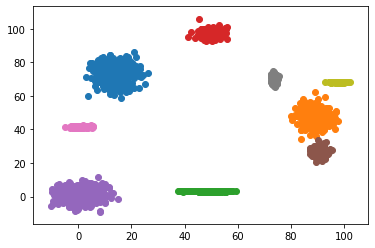

convexe


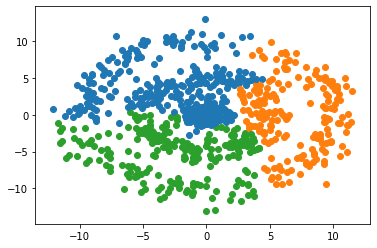

sep


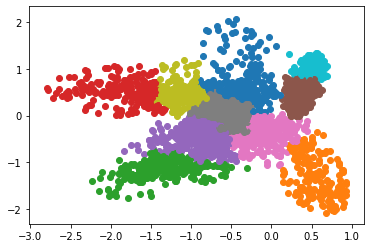

dens


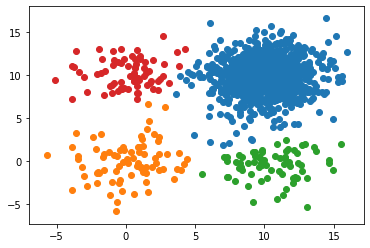

bruit


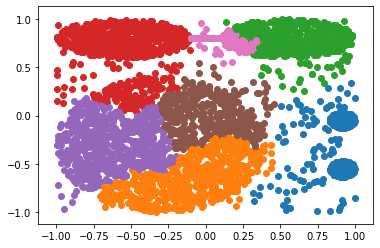

In [77]:
for i in dataArray:
    print(i[1])
    pred,tmps = agglo_pred(i[2],'ward',i[0])
    plotColor(i[0],pred)

In [ ]:
########################## DBSCAN ################################

In [5]:
from sklearn.cluster import DBSCAN

def dbscan_pred(eps,min_sample,data):
    # parametres pour le kmeans
    dbscan = DBSCAN(eps=eps,min_samples=min_sample)

    # calcul le temps d'exe
    start = time.time()

    # training
    dbscan.fit(data)

    tmps = time.time()-start

    # prediction
    pred = dbscan.fit_predict(data)
    return (pred,tmps)


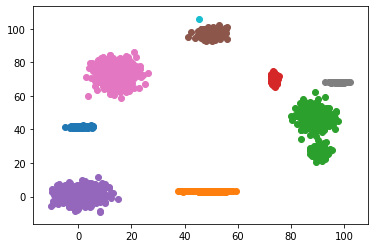

In [94]:
pred,tmps = dbscan_pred(5.0,10,dataRef[0])
plotColor(dataRef[0],pred)

eps = 1.0


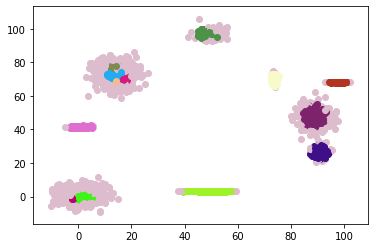

eps = 2.0


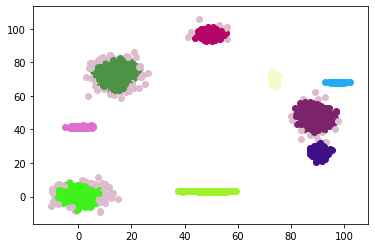

eps = 3.0


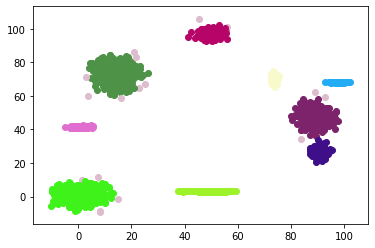

eps = 4.0


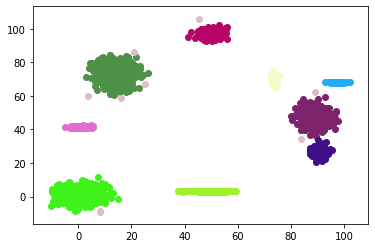

eps = 5.0


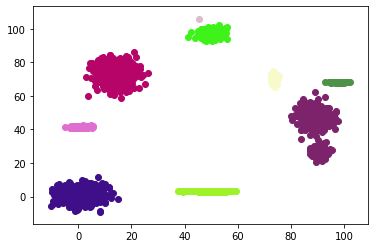

eps = 6.0


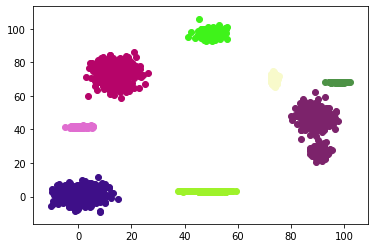

eps = 7.0


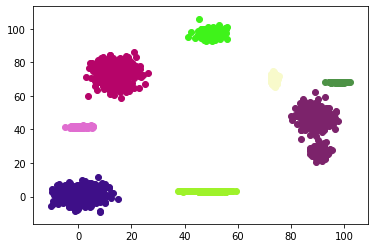

eps = 8.0


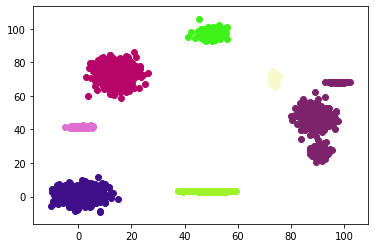

eps = 9.0


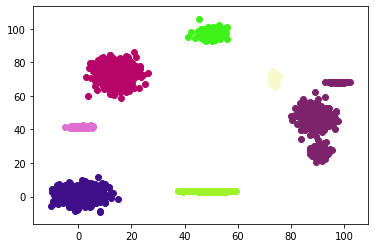

In [109]:
# test des parametres eps
for i in np.arange(1.0,10.0,1.0):
    print('eps = '+ str(i))
    pred,tmps = dbscan_pred(i,10,dataRef[0])
    plotColor(dataRef[0],pred)

min-sample = 1


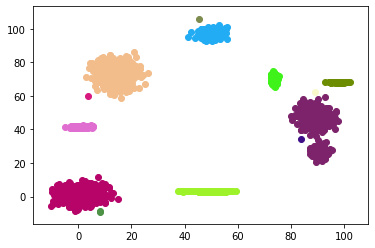

min-sample = 2


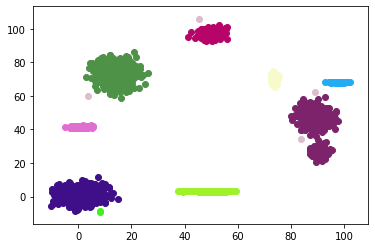

min-sample = 3


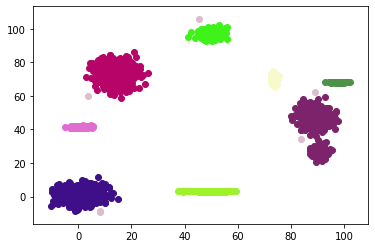

min-sample = 4


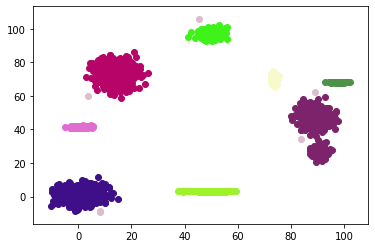

min-sample = 5


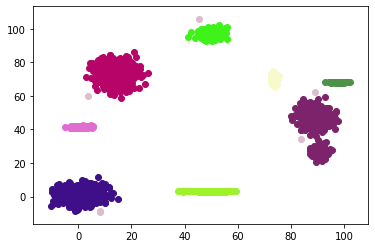

min-sample = 6


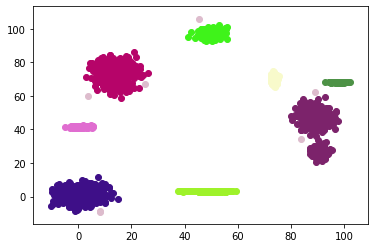

min-sample = 7


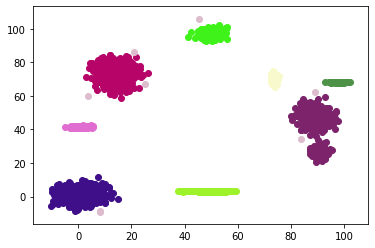

min-sample = 8


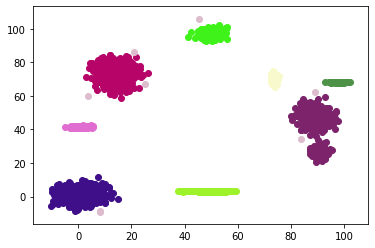

min-sample = 9


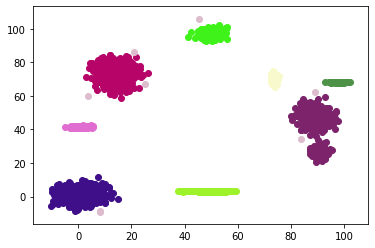

min-sample = 10


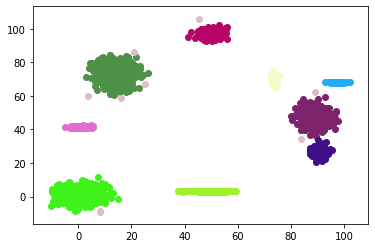

min-sample = 11


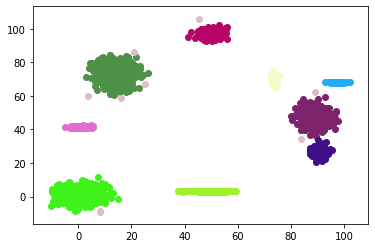

min-sample = 12


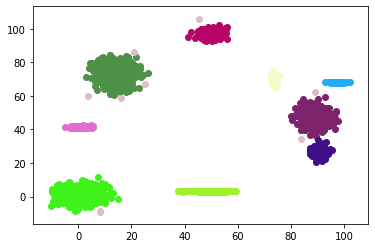

min-sample = 13


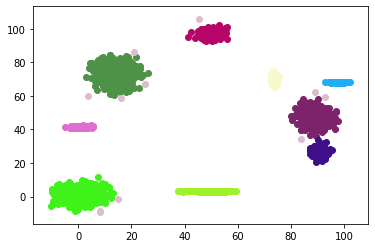

min-sample = 14


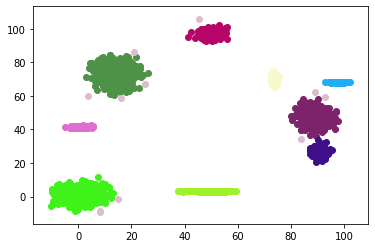

In [114]:
# test des parametres min_sample
for i in range(1,15):
    print('min-sample = '+ str(i))
    pred,tmps = dbscan_pred(4.0,i,dataRef[0])
    plotColor(dataRef[0],pred)
    
              

eps = 1.0
min-sample = 1
sil : 0.16387420614692558
cal : 3584.7345718315387
dav : 0.44792112386147936


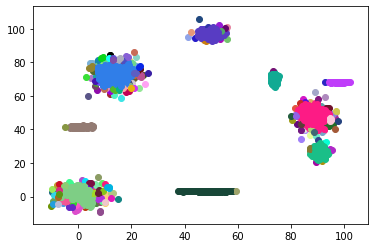

eps = 1.0
min-sample = 3
sil : 0.4148670651399852
cal : 1239.1388418701586
dav : 1.0440635070789177


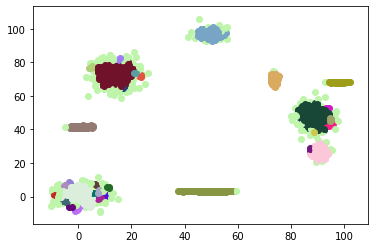

eps = 1.0
min-sample = 5
sil : 0.4593930658025584
cal : 1105.2765676616366
dav : 1.1293131032021348


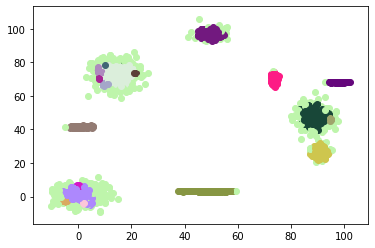

eps = 1.0
min-sample = 7
sil : 0.447535008887289
cal : 755.5878296243279
dav : 1.0973181030515193


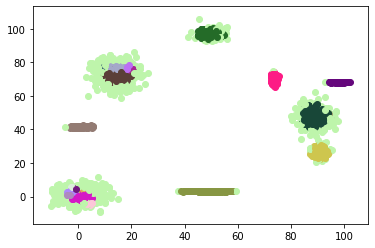

eps = 1.0
min-sample = 9
sil : 0.458682040048421
cal : 647.3784861830632
dav : 1.1962314317283826


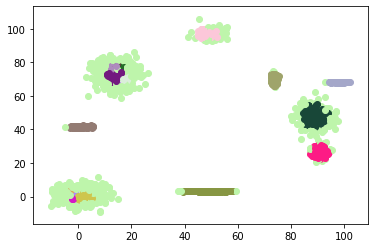

eps = 1.0
min-sample = 11
sil : 0.4126936786164132
cal : 673.8348779900417
dav : 1.2055747931540606


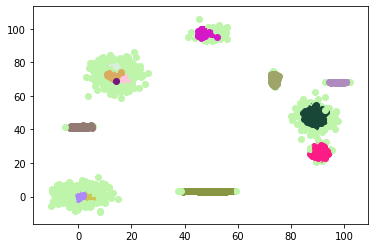

eps = 1.0
min-sample = 13
sil : 0.25191692698131335
cal : 514.6142259959183
dav : 1.1691601379607013


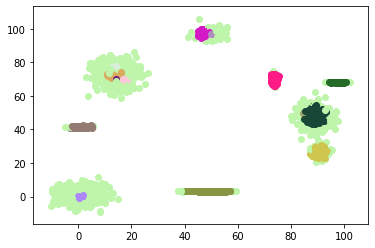

eps = 3.0
min-sample = 1
sil : 0.4154164637376692
cal : 8308.541259574067
dav : 0.4817555150313828


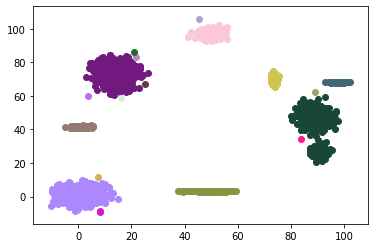

eps = 3.0
min-sample = 3
sil : 0.7733470827465355
cal : 15078.938576862205
dav : 1.1292898464291063


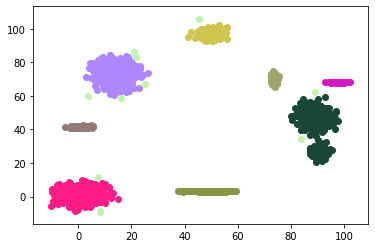

eps = 3.0
min-sample = 5
sil : 0.8335411505260097
cal : 29027.9137782882
dav : 1.0817172477755368


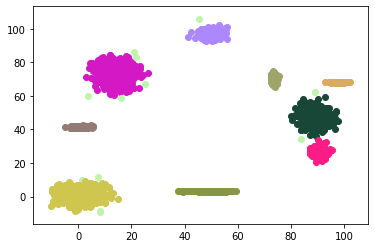

eps = 3.0
min-sample = 7
sil : 0.8326092928033721
cal : 26404.43837055006
dav : 1.0992042202728323


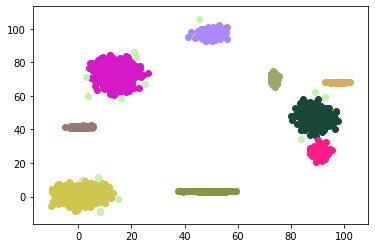

eps = 3.0
min-sample = 9
sil : 0.8321188546424285
cal : 25361.844212359763
dav : 1.1288939167611267


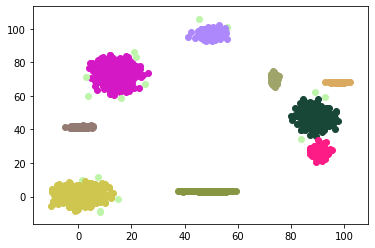

eps = 3.0
min-sample = 11
sil : 0.8292146343918
cal : 21683.08246197532
dav : 1.0967879765224864


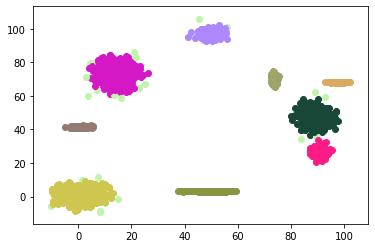

eps = 3.0
min-sample = 13
sil : 0.8260178579421974
cal : 19532.45297670341
dav : 1.0967933681815756


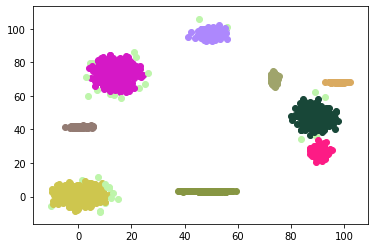

eps = 5.0
min-sample = 1
sil : 0.7373288555059309
cal : 17443.35464783175
dav : 0.26962008179517427


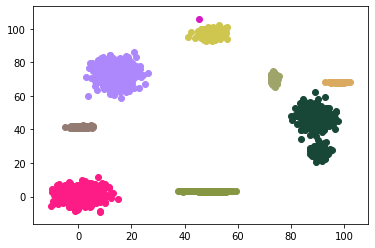

eps = 5.0
min-sample = 3
sil : 0.7373288555059309
cal : 17443.35464783175
dav : 0.26962008179517427


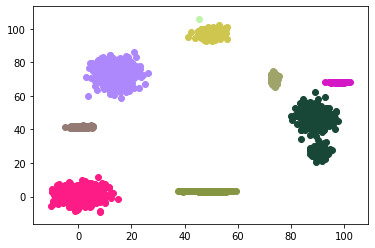

eps = 5.0
min-sample = 5
sil : 0.7373288555059309
cal : 17443.35464783175
dav : 0.26962008179517427


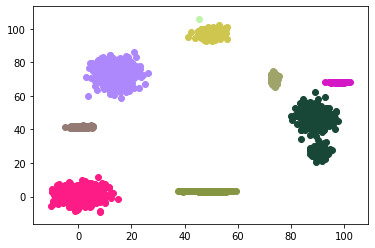

eps = 5.0
min-sample = 7
sil : 0.7373288555059309
cal : 17443.35464783175
dav : 0.26962008179517427


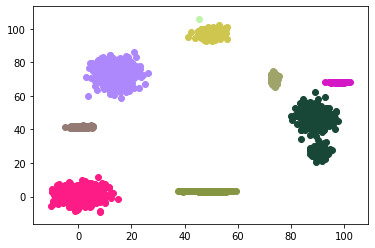

eps = 5.0
min-sample = 9
sil : 0.7373288555059309
cal : 17443.35464783175
dav : 0.26962008179517427


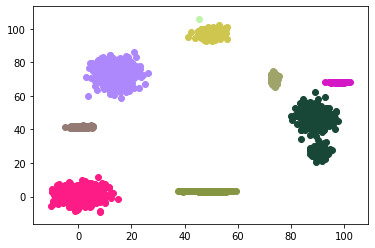

eps = 5.0
min-sample = 11
sil : 0.7373288555059309
cal : 17443.35464783175
dav : 0.26962008179517427


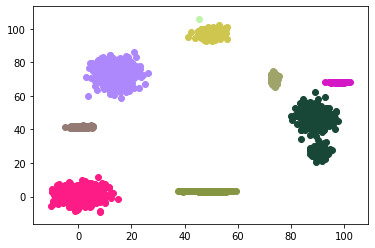

eps = 5.0
min-sample = 13
sil : 0.7373288555059309
cal : 17443.35464783175
dav : 0.26962008179517427


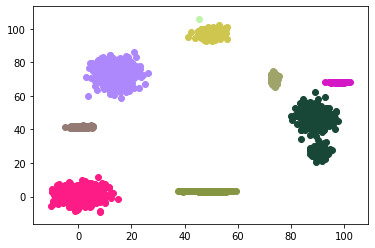

eps = 7.0
min-sample = 1
sil : 0.7525629204969061
cal : 14975.373577345592
dav : 0.2767188824821737


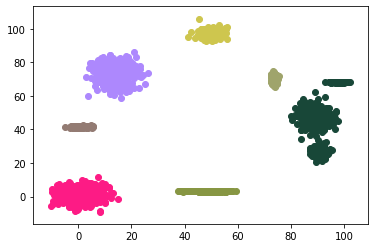

eps = 7.0
min-sample = 3
sil : 0.7525629204969061
cal : 14975.373577345592
dav : 0.2767188824821737


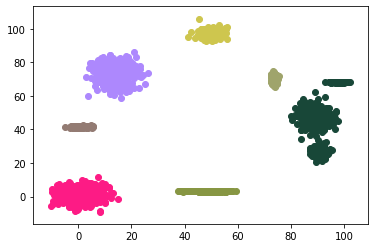

eps = 7.0
min-sample = 5
sil : 0.7525629204969061
cal : 14975.373577345592
dav : 0.2767188824821737


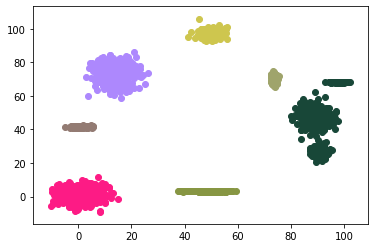

eps = 7.0
min-sample = 7
sil : 0.7525629204969061
cal : 14975.373577345592
dav : 0.2767188824821737


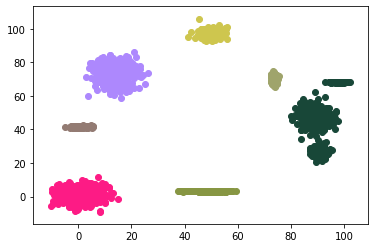

eps = 7.0
min-sample = 9
sil : 0.7525629204969061
cal : 14975.373577345592
dav : 0.2767188824821737


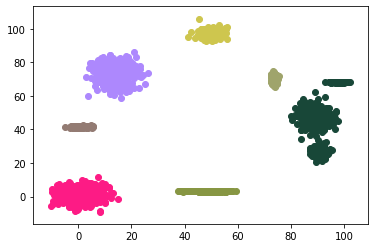

eps = 7.0
min-sample = 11
sil : 0.7771329700076133
cal : 19931.738270015536
dav : 0.27411504115090624


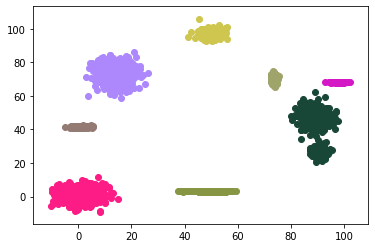

eps = 7.0
min-sample = 13
sil : 0.7771329700076133
cal : 19931.738270015536
dav : 0.27411504115090624


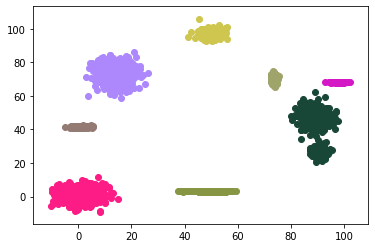

eps = 9.0
min-sample = 1
sil : 0.7525629204969061
cal : 14975.373577345592
dav : 0.2767188824821737


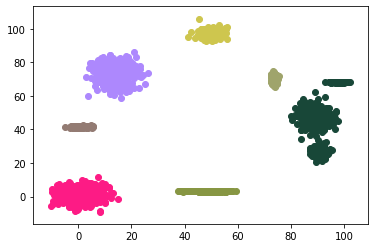

eps = 9.0
min-sample = 3
sil : 0.7525629204969061
cal : 14975.373577345592
dav : 0.2767188824821737


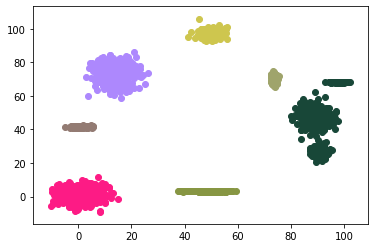

eps = 9.0
min-sample = 5
sil : 0.7525629204969061
cal : 14975.373577345592
dav : 0.2767188824821737


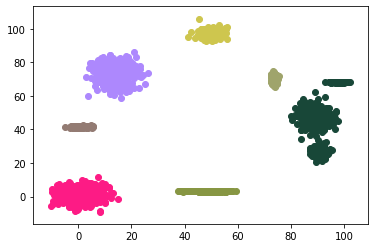

eps = 9.0
min-sample = 7
sil : 0.7525629204969061
cal : 14975.373577345592
dav : 0.2767188824821737


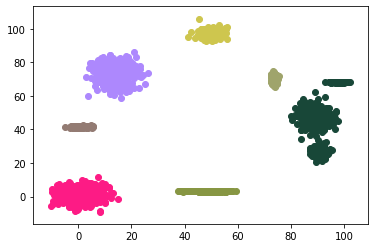

eps = 9.0
min-sample = 9
sil : 0.7525629204969061
cal : 14975.373577345592
dav : 0.2767188824821737


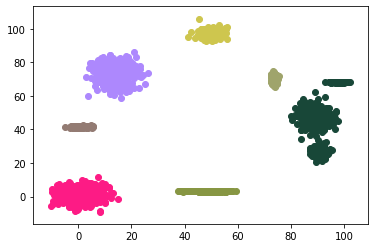

eps = 9.0
min-sample = 11
sil : 0.7525629204969061
cal : 14975.373577345592
dav : 0.2767188824821737


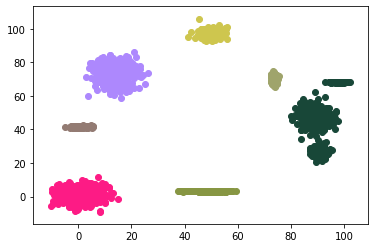

eps = 9.0
min-sample = 13
sil : 0.7525629204969061
cal : 14975.373577345592
dav : 0.2767188824821737


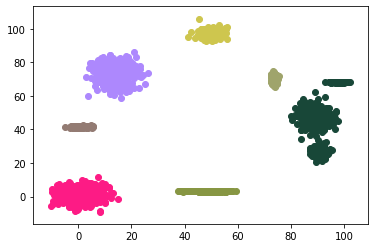

In [121]:
# test des parametres eps ET min-sample
for eps in np.arange(1.0,10.0,2.0):
    for min_sample in range(1,15,2):
        print('eps = '+ str(eps))
        print('min-sample = '+ str(min_sample)) 
         
        pred,tmps = dbscan_pred(eps,min_sample,dataRef[0])
                              
        sil,cal,dav = evaluate_score(dataRef[0],pred)
        print('sil : '+ str(sil))
        print('cal : '+ str(cal))
        print('dav : '+ str(dav))
              
        plotColor(dataRef[0],pred)
        


In [20]:
## rq : faire une courbe des scores en fonction des valeurs de eps et min-range pour plus de clarete

def find_param_dbscan(data):


    rng_eps = np.arange(1.0,10.0,1.0)
    rng_min_sample = range(1,15,1)
    
    for eps in rng_eps:
        sil = []
        cal = []
        dav = []
        tmps = []
        for min_sample in rng_min_sample:
            # predit avec des valeur de min et eps
            pred,tmp = dbscan_pred(eps,min_sample,data)
            tmps.append(tmp)
            
            # evalue
            a,b,c = evaluate_score(data,pred)
            sil.append(a)
            cal.append(b)
            dav.append(c)
       
        # plot 
        plt.figure()
        fig,axs = plt.subplots(4, 1)
        axs[0].plot(rng_min_sample,sil,'r')
        axs[0].set_title('Eps : ' + str(eps) + ' pour sil')
        #plt.figure()
        axs[1].plot(rng_min_sample,cal,'b')
        axs[1].set_title('Eps : ' + str(eps) + ' pour cal')
        #plt.figure()
        axs[2].plot(rng_min_sample,dav,'g')
        axs[2].set_title('Eps : ' + str(eps) + ' pour dav')
        #plt.figure()
        axs[3].plot(rng_min_sample,tmps,'y')
        axs[3].set_title('Eps : ' + str(eps) + ' temps')


#https://matplotlib.org/devdocs/gallery/subplots_axes_and_figures/subplots_demo.html


<Figure size 432x288 with 0 Axes>

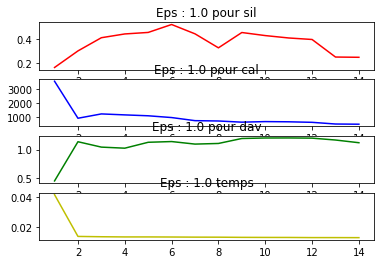

<Figure size 432x288 with 0 Axes>

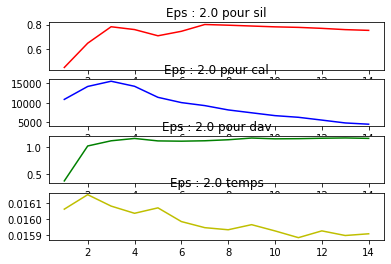

<Figure size 432x288 with 0 Axes>

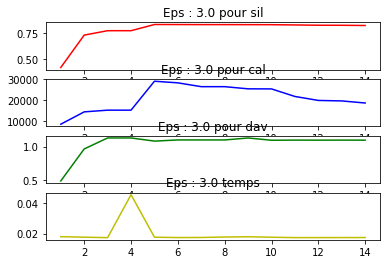

<Figure size 432x288 with 0 Axes>

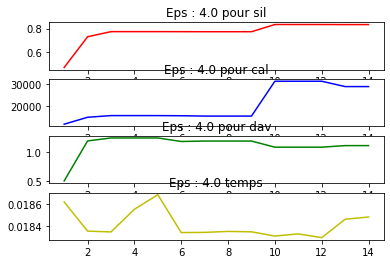

<Figure size 432x288 with 0 Axes>

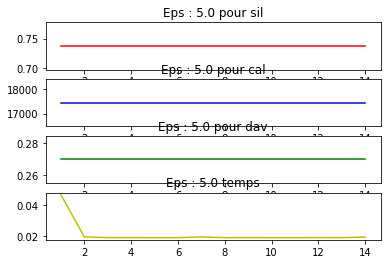

<Figure size 432x288 with 0 Axes>

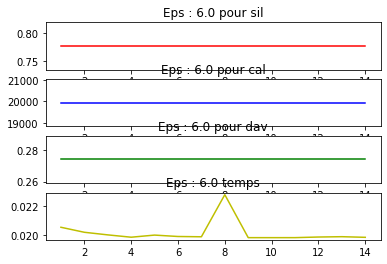

<Figure size 432x288 with 0 Axes>

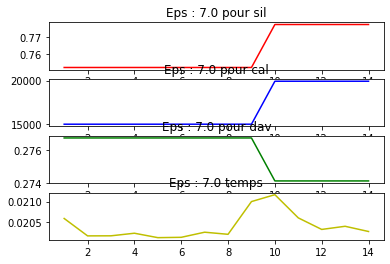

<Figure size 432x288 with 0 Axes>

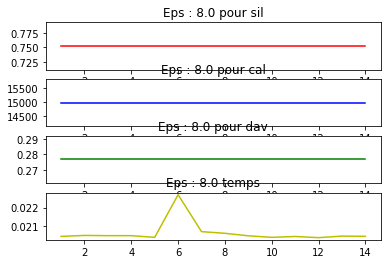

<Figure size 432x288 with 0 Axes>

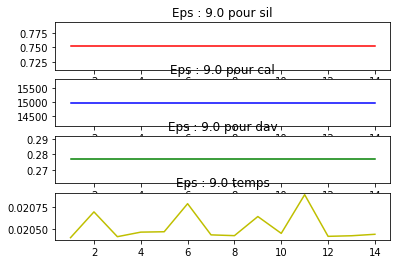

In [21]:
find_param_dbscan(dataRef[0])
# ajouter le nom de chaque courbe

ref
convexe


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

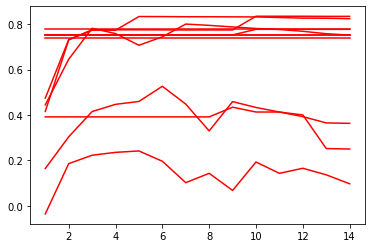

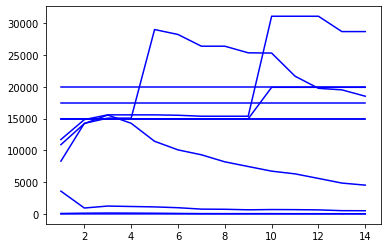

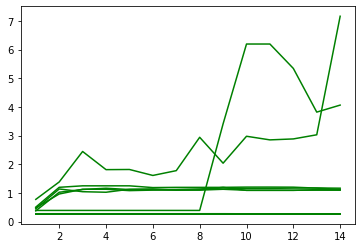

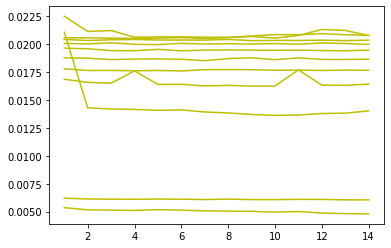

In [127]:
# meilleure combinaison : min-sample = 10 et eps = 4
# application a tous les dataset

for data in dataArray:
    print(data[1])
    find_param_dbscan(data[0])


In [ ]:
################################## HDBSCAN ###################################

In [45]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_samples=10)
#pred = clusterer.fit_predict(dataRef[0])

0.041916608810424805


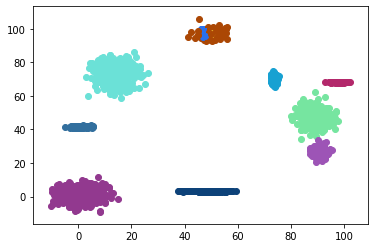

0.01316070556640625


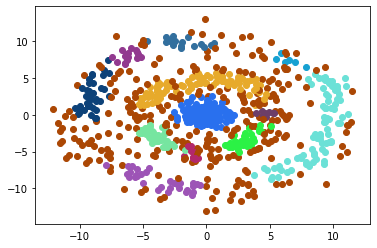

0.0382075309753418


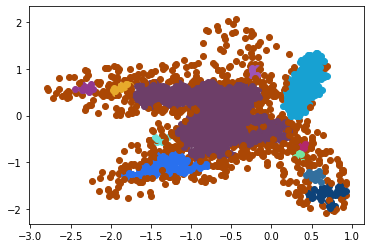

0.020277023315429688


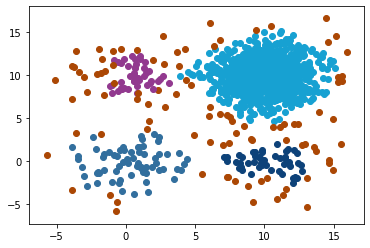

0.05948662757873535


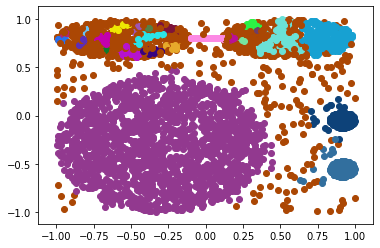

In [46]:
for data in dataArray:
    tmp = time.time()
    pred = clusterer.fit_predict(data[0])
    print(str(time.time() - tmp))
    plotColor(data[0], pred)
